### Описание датасета
-  Регион - субъект Российской Федерации, где находится медицинское учреждение
-  Календарный_год - год  
-  Период - месяц
-  gender - пол респондента
-  poselenie - ответ на вопрос "Вы постоянно проживаете в городе или в сельской местности?"
-  Населенный_пункт - название населенного пункта, где находится медицинское учреждение
-  org_type - ответ на вопрос "В каких организациях Вы обычно получаете медицинскую помощь?"
-  last_visit - ответ на вопрос "Как давно Вы в последний раз получали медицинскую помощь?"
-  time_of_register - ответ на вопрос "Насколько Вы согласны с утверждением, что сейчас Вы можете записаться к врачу в удобное для Вас время?"
-  wait_time - ответ на вопрос "Насколько Вы удовлетворены длительностью ожидания медицинской услуги с момента возникновения потребности в медицинской помощи до момента ее получения?"
-  near_cab - ответ на вопрос "Насколько Вы удовлетворены длительностью ожидания непосредственно перед кабинетом?"
-  comfort - ответ на вопрос "Насколько комфортным было Ваше пребывание в медицинской организации (комфортность зон ожидания, комфортное перемещение внутри медицинской организации)?"
-  attitude - ответ на вопрос "Насколько Вы удовлетворены отношением к Вам со стороны медицинского персонала (врачи, мед. сестры, регистраторы, санитары)?"
-  explain - ответ на вопрос "Удовлетворены ли Вы тем, как врач объяснял Вам, зачем назначено то или иное лечение, лекарственный препарат, диагностическая процедура?"
-  expect - ответ на вопрос "Насколько результат Вашего обращения в медицинскую организацию соответствовал Вашим ожиданиям?"
-  loyalty - ответ на вопрос "Вы бы посоветовали близким друзьям или родственникам обращаться за медицинской помощью в Вашу медицинскую организацию?"
-  gen_sat - ответ на вопрос "Оцените, насколько в целом Вы удовлетворены медицинской помощью?"
-  open_question_1 - ответ на вопрос "Что Вы можете назвать наибольшей проблемой в процессе получения медицинской помощи в медицинской организации, в которой Вы получаете медицинскую помощь?"
-  open_question_2 - ответ на вопрос "Что Вы можете назвать наибольшей проблемой в процессе получения медицинской помощи в регионе, в котором Вы проживаете?"
-  date_of_survey - дата опроса
-  respondent_number - номер респондента
-  doctor_domestic_visit_problem - ответ на вопрос "Возникали ли у Вас сложности при вызове врача на дом?"
-  diag_services_available - ответ на вопрос "Можете ли Вы получить при оказании первичной медико-санитарной помощи в Вашей медицинской организации диагностические и лабораторные услуги?"
-  disabled_facilitites_available - ответ на вопрос "Есть ли в Вашей медицинской организации приспособления для лиц с ограниченными возможностями?
- problem_solved - ответ на вопрос "Была ли решена Ваша медицинская проблема?"

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import mlflow
import mlflow.sklearn
import os
from datetime import datetime
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [23]:
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

In [24]:
from tqdm import tqdm
tqdm.pandas()

In [25]:
df = pd.read_csv('Downloads/Anketa_short.csv', on_bad_lines='warn', sep=',')
df.shape

(196289, 27)

#### Целевой признак и обработка пропусков

In [26]:
# Целевой признак: problem_solved
df['problem_solved'] = df['problem_solved'].map({'Да': 1, 'Нет': 0})
df = df.dropna(subset=['problem_solved'])
df['problem_solved'] = df['problem_solved'].astype(int)

# Удаляем ненужные колонки
df = df.drop(columns=['respondent_number'])

In [27]:
print("После удаления пропусков:", df.shape)

После удаления пропусков: (165202, 26)


#### EDA

In [28]:
# Пропуски
print("\n🔍 Пропущенные значения:\n", df.isnull().sum())


🔍 Пропущенные значения:
 Регион                                0
Календарный_год                       0
Период                                0
gender                                0
poselenie                             0
Населенный_пункт                      1
org_type                              1
last_visit                           33
time_of_register                      1
wait_time                             0
near_cab                              0
comfort                               0
attitude                              1
explain                               1
expect                                4
loyalty                               1
gen_sat                               0
open_question_1                   19667
open_question_2                   24496
date_of_survey                        0
doctor_domestic_visit_problem      1757
diag_services_available            3581
disabled_facilitites_available     3661
region_medical_care                1673
age           

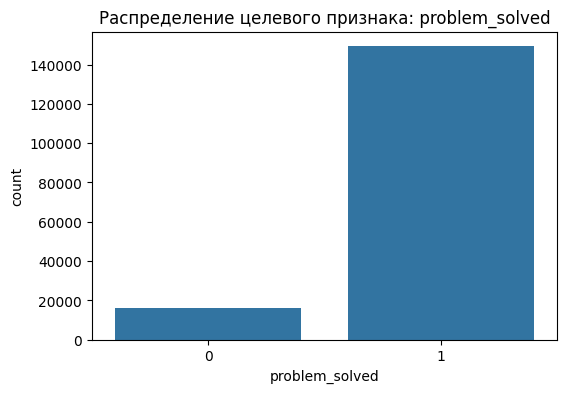

In [29]:
# Распределение целевого признака
plt.figure(figsize=(6, 4))
sns.countplot(x='problem_solved', data=df)
plt.title('Распределение целевого признака: problem_solved')
plt.show()

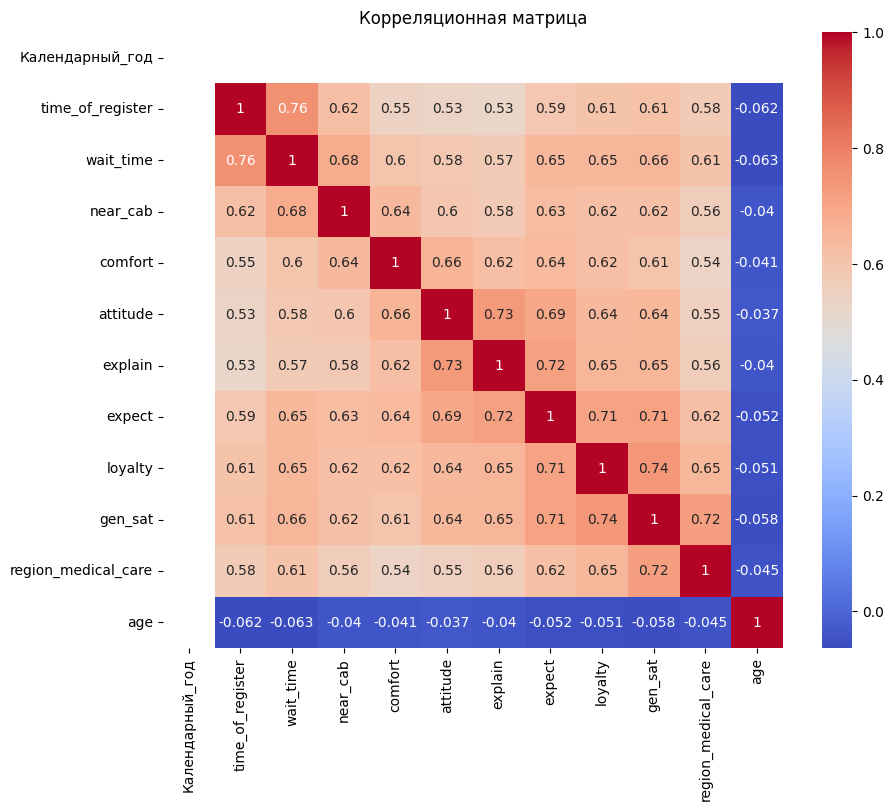

In [30]:
# Корреляция числовых признаков
numeric_cols = df.select_dtypes(include=np.number).drop(columns=['problem_solved']).columns
corr = df[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()

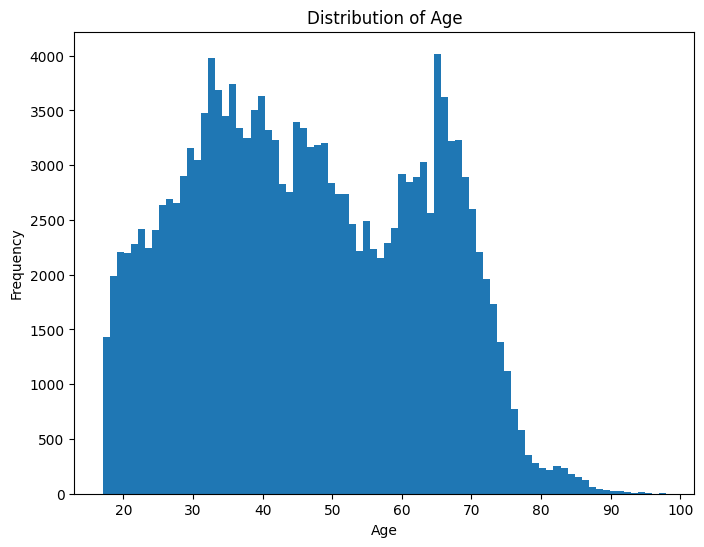

In [31]:
plt.figure(figsize=(8, 6))
df['age'].plot(kind='hist', bins=80)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Age')
plt.show()
# TODO Можно также посмотреть как меняется возраст в завсисмости от региона и даты

In [ ]:
# TODO проверить гипотезу от разной значимости признаков для женщин и мужчин

In [ ]:
# TODO могут быть подозрительные данные, когда ту же самую анекету залили в следующем периоде

In [9]:
# TODO доделать преобразование в координаты и создание карты
# df.drop_duplicates(inplace=True)
#df_sample = df.sample(n=10).copy()

In [32]:
'''
# Инициализация геокодера
geolocator = Nominatim(user_agent="geo_example")

# Название села
# location = geolocator.geocode("село Лопатино, Россия")

geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

df_sample['geo_coordinates'] = df_sample['Населенный_пункт'].progress_apply(lambda x: (None, None) if pd.isna(x) else geocode(x))


df_sample['latitude'] = df_sample['geo_coordinates'].progress_apply(lambda loc: loc.latitude if loc else None)
df_sample['longitude'] = df_sample['geo_coordinates'].progress_apply(lambda loc: loc.longitude if loc else None)


display(df_sample.head())


missing_coordinates_count = df_sample['geo_coordinates'].isnull().sum()
print(f"\nNumber of rows with missing coordinates: {missing_coordinates_count}")
'''

'\n# Инициализация геокодера\ngeolocator = Nominatim(user_agent="geo_example")\n\n# Название села\n# location = geolocator.geocode("село Лопатино, Россия")\n\ngeocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)\n\ndf_sample[\'geo_coordinates\'] = df_sample[\'Населенный_пункт\'].progress_apply(lambda x: (None, None) if pd.isna(x) else geocode(x))\n\n\ndf_sample[\'latitude\'] = df_sample[\'geo_coordinates\'].progress_apply(lambda loc: loc.latitude if loc else None)\ndf_sample[\'longitude\'] = df_sample[\'geo_coordinates\'].progress_apply(lambda loc: loc.longitude if loc else None)\n\n\ndisplay(df_sample.head())\n\n\nmissing_coordinates_count = df_sample[\'geo_coordinates\'].isnull().sum()\nprint(f"\nNumber of rows with missing coordinates: {missing_coordinates_count}")\n'

In [ ]:
# TODO обработать текст open_question_1 и open_question_2

### Feature Engineering

In [36]:
# 1. Средняя удовлетворенность по всем шкалам
satisfaction_columns = ['time_of_register', 'wait_time', 'near_cab', 'comfort',
                        'attitude', 'explain', 'expect']
df['avg_satisfaction'] = df[satisfaction_columns].mean(axis=1)

# 2. Возрастные группы
bins = [0, 18, 30, 45, 60, 100]
labels = ['<18', '18-30', '31-45', '46-60', '>60']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels)

# 3. Месяц из даты опроса
df['date_of_survey'] = pd.to_datetime(df['date_of_survey'], errors='coerce')
df['survey_date_month'] = pd.to_datetime(df['date_of_survey']).dt.month

# 4. Длительность последнего визита (переводим в месяцы)
visit_map = {
    'менее 1 мес. назад': 0.5,
    'от 1 до 3 мес. назад': 2,
    'от 4 до 6 мес. назад': 5,
    'от 7 до 12 мес. назад': 9.5,
    'более 12 мес. назад': 15
}
df['last_visit_months'] = df['last_visit'].map(visit_map)

# 5. Наличие проблем с вызовом врача на дом
df['has_home_visit_problem'] = df['doctor_domestic_visit_problem'].apply(lambda x: 1 if x == 'Да' else 0)

# 6. Есть ли диагностические услуги
df['diag_available'] = df['diag_services_available'].apply(lambda x: 1 if x == 'Да' else 0)

# 7. Наличие удобств для инвалидов
df['disabled_facilities'] = df['disabled_facilitites_available'].apply(lambda x: 1 if x == 'Да' else 0)

# 8. Город/село
df['is_urban'] = df['poselenie'].map({'Город': 1, 'Село': 0})

# 9. Частота обращений (обратная величина last_visit_months)
df['visit_frequency'] = 1 / (df['last_visit_months'] + 0.1)

# 10. Тип организации (государственная или нет)
df['org_type'] = df['org_type'].fillna('Преимущественно в государственных')
df['is_state_org'] = df['org_type'].str.contains('государственных').astype(int)

In [37]:
df

,Регион,Календарный_год,Период,gender,poselenie,Населенный_пункт,org_type,last_visit,time_of_register,wait_time,near_cab,comfort,attitude,explain,expect,loyalty,gen_sat,open_question_1,open_question_2,date_of_survey,doctor_domestic_visit_problem,diag_services_available,disabled_facilitites_available,region_medical_care,age,problem_solved,avg_satisfaction,age_group,survey_date_month,last_visit_months,has_home_visit_problem,diag_available,disabled_facilities,is_urban,visit_frequency,is_state_org
0,Краснодарский край,2023,Январь,Мужской,Город,Приморско-Ахтарск,Преимущественно в государственных,от 4 до 6 мес. назад,5.000,5.000,5.000,6.000,6.000,6.000,5.000,6.000,6,-,-,2023-01-23,Нет,Да,Да,6.000,61.000,1,5.429,>60,1.000,5.000,0,1,1,1,0.196,1
1,Краснодарский край,2023,Январь,Мужской,Город,Краснодар,Преимущественно в государственных,от 4 до 6 мес. назад,5.000,5.000,5.000,4.000,5.000,5.000,6.000,5.000,5,-,-,2023-01-23,Нет,Да,Да,5.000,67.000,1,5.000,>60,1.000,5.000,0,1,1,1,0.196,1
2,Краснодарский край,2023,Январь,Мужской,Город,Краснодар,Преимущественно в государственных,от 1 до 3 мес. назад,4.000,5.000,5.000,4.000,5.000,5.000,4.000,5.000,5,-,-,2023-01-23,Нет,Да,Да,5.000,71.000,1,4.571,>60,1.000,2.000,0,1,1,1,0.476,1
3,Краснодарский край,2023,Январь,Мужской,Город,Сочи,Только в частных,более 12 мес. назад,5.000,6.000,6.000,6.000,5.000,6.000,6.000,6.000,6,-,-,2023-01-23,Не пользовался данной услугой,Да,Да,6.000,33.000,1,5.714,31-45,1.000,15.000,0,1,1,1,0.066,0
4,Краснодарский край,2023,Январь,Мужской,Город,Туапсе,Преимущественно в государственных,от 4 до 6 мес. назад,5.000,6.000,5.000,6.000,6.000,6.000,6.000,5.000,6,-,-,2023-01-23,Нет,Да,Да,6.000,49.000,1,5.714,46-60,1.000,5.000,0,1,1,1,0.196,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196283,Свердловская область,2023,Июль,Мужской,Город,Серов,Преимущественно в государственных,от 4 до 6 мес. назад,4.000,4.000,4.000,4.000,4.000,4.000,4.000,5.000,4,Не развита телемедицина,Отсутствие узких специалистов,2023-07-10,Нет,Да,Да,4.000,36.000,1,4.000,31-45,7.000,5.000,0,1,1,1,0.196,1
196285,Свердловская область,2023,Июль,Мужской,Город,Карпинск,Преимущественно в государственных,от 7 до 12 мес. назад,4.000,3.000,3.000,4.000,5.000,5.000,4.000,4.000,4,Недостаточно врачей и персонала,Отсутствие узких специалистов,2023-07-10,Нет,Да,Да,3.000,49.000,1,4.000,46-60,7.000,9.500,0,1,1,1,0.104,1
196286,Свердловская область,2023,Июль,Мужской,Город,Карпинск,Преимущественно в государственных,от 4 до 6 мес. назад,4.000,4.000,4.000,4.000,4.000,4.000,4.000,4.000,4,Недостаточно врачей и персонала,Недоступность современных исследований,2023-07-10,Нет,Да,Да,4.000,69.000,1,4.000,>60,7.000,5.000,0,1,1,1,0.196,1
196287,Свердловская область,2023,Июль,Женский,Село,Калья,Преимущественно в государственных,от 1 до 3 мес. назад,4.000,4.000,3.000,4.000,4.000,4.000,4.000,4.000,4,Недостаточно врачей и персонала,Недоступность современных исследований,2023-07-10,Нет,Да,Да,4.000,63.000,1,3.857,>60,7.000,2.000,0,1,1,0,0.476,1


### Baseline модель

In [43]:
# Удаление лишних столбцов
X = df.drop(columns=['poselenie', 'org_type', 'problem_solved', 'open_question_1', 'open_question_2', 'date_of_survey', 'doctor_domestic_visit_problem', 'diag_services_available', 'disabled_facilitites_available', 'last_visit', 'Период', 'gender', 'Населенный_пункт', 'Регион'])
y = df['problem_solved']

categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()

# Предобработка
preprocessor = ColumnTransformer([
    ('num', SimpleImputer(strategy='median'), numerical_cols),
    ('cat', SimpleImputer(strategy='most_frequent'), categorical_cols),
])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler(with_mean=False)),
    ('feature_selector', SelectKBest(score_func=f_classif, k=15)),
])




In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [45]:
X_train

,Календарный_год,time_of_register,wait_time,near_cab,comfort,attitude,explain,expect,loyalty,gen_sat,region_medical_care,age,avg_satisfaction,age_group,survey_date_month,last_visit_months,has_home_visit_problem,diag_available,disabled_facilities,is_urban,visit_frequency,is_state_org
49801,2023,3.000,5.000,4.000,4.000,5.000,5.000,5.000,5.000,5,5.000,35.000,4.429,31-45,3.000,2.000,0,1,1,1,0.476,1
114509,2023,4.000,4.000,4.000,4.000,5.000,4.000,4.000,4.000,4,4.000,58.000,4.143,46-60,5.000,9.500,0,1,1,1,0.104,1
193907,2023,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5,5.000,31.000,5.000,31-45,7.000,15.000,0,1,1,1,0.066,1
190475,2023,3.000,3.000,4.000,5.000,3.000,4.000,3.000,3.000,4,4.000,68.000,3.571,>60,7.000,2.000,1,1,1,0,0.476,1
70430,2023,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5,5.000,42.000,5.000,31-45,3.000,2.000,0,1,1,0,0.476,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191093,2023,6.000,6.000,6.000,6.000,6.000,6.000,6.000,6.000,6,6.000,37.000,6.000,31-45,7.000,2.000,0,1,1,0,0.476,1
56231,2023,4.000,4.000,4.000,4.000,5.000,4.000,4.000,5.000,5,4.000,77.000,4.143,>60,3.000,9.500,0,1,1,0,0.104,1
47703,2023,4.000,4.000,5.000,5.000,5.000,5.000,4.000,4.000,5,5.000,33.000,4.571,31-45,3.000,15.000,0,1,0,1,0.066,1
63038,2023,5.000,6.000,5.000,6.000,6.000,6.000,6.000,6.000,6,6.000,46.000,5.714,46-60,3.000,15.000,0,1,1,1,0.066,1


In [47]:
X_train_prepared = pipeline.fit_transform(X_train, y_train)
X_test_prepared = pipeline.transform(X_test)

print("Размер обработанной выборки:", X_train_prepared.shape)

Размер обработанной выборки: (132161, 15)


C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.39      0.51      3167
           1       0.94      0.99      0.96     29874

    accuracy                           0.93     33041
   macro avg       0.84      0.69      0.74     33041
weighted avg       0.92      0.93      0.92     33041

ROC AUC Score: 0.8856199881201923


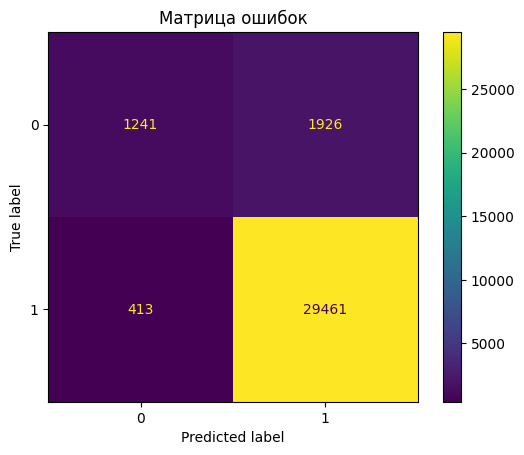

In [48]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_prepared, y_train)
y_pred = model.predict(X_test_prepared)
y_proba = model.predict_proba(X_test_prepared)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

ConfusionMatrixDisplay.from_estimator(model, X_test_prepared, y_test)
plt.title("Матрица ошибок")
plt.show()

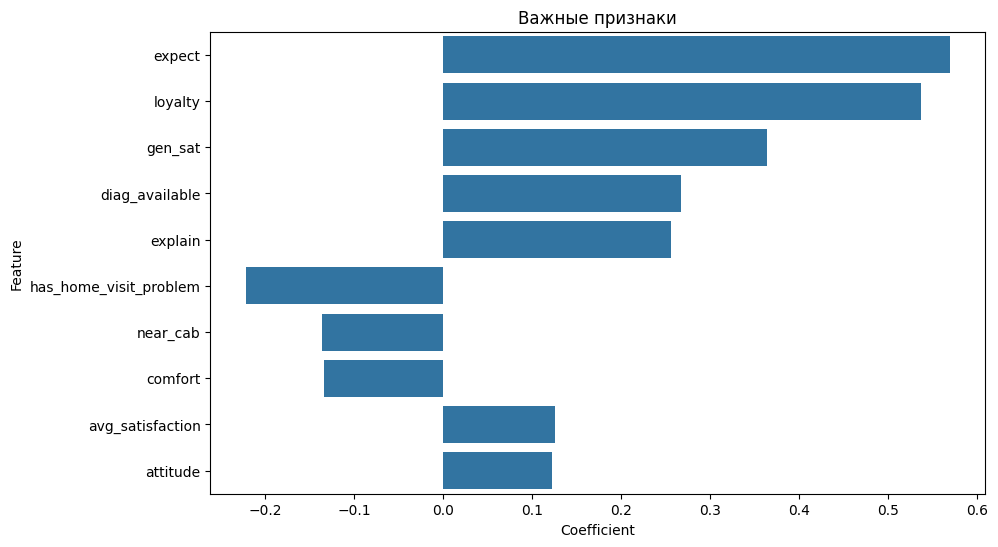

In [49]:
selected_features = pipeline.named_steps['feature_selector'].get_support(indices=True)
all_features = numerical_cols + categorical_cols
top_features = [all_features[i] for i in selected_features]

coefs = model.coef_[0]
coef_df = pd.DataFrame(zip(top_features, coefs), columns=["Feature", "Coefficient"])
coef_df["abs_coef"] = coef_df["Coefficient"].abs()
coef_df = coef_df.sort_values(by="abs_coef", ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x="Coefficient", y="Feature", data=coef_df)
plt.title("Важные признаки")
plt.show()

In [50]:
mlflow.set_tracking_uri("http://127.0.0.1:5000/") 
mlflow.set_experiment("Medical_Survey_Analysis")

with mlflow.start_run():
    mlflow.log_param("model_type", "LogisticRegression")
    mlflow.log_metric("roc_auc", roc_auc_score(y_test, y_proba))
    mlflow.log_metric("accuracy", model.score(X_test_prepared, y_test))
    
    # Сохраняем модель
    mlflow.sklearn.log_model(model, "model")

2025/05/23 21:07:20 INFO mlflow.tracking.fluent: Experiment with name 'Medical_Survey_Analysis' does not exist. Creating a new experiment.
2025/05/23 21:07:20 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
  

🏃 View run gifted-fly-527 at: http://127.0.0.1:5000/#/experiments/428328559253118491/runs/b6dbfec72d8d4ba7b106d98052a3603e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/428328559253118491


NameError: name '__file__' is not defined